# Agrupación de Países usando Aprendizaje No Supervisado para HELP International
<div style="text-align: center;">
  <img src="https://static.vecteezy.com/system/resources/previews/025/466/187/original/world-map-abstract-map-of-planet-made-with-binary-code-global-network-connection-futuristic-background-with-map-of-planet-earth-digital-binary-data-and-streaming-digital-code-illustration-vector.jpg" width="600" height="300" style="display: block; margin: auto;">
</div>


**Objetivo:**

Categorizar los países utilizando factores socioeconómicos y de salud que determinan el desarrollo general de cada país.

**Sobre la organización:**

HELP International es una ONG humanitaria internacional comprometida con la lucha contra la pobreza y la provisión de servicios básicos y asistencia a las personas de países subdesarrollados, especialmente durante desastres y calamidades naturales.

**Planteamiento del problema:**

HELP International ha logrado recaudar alrededor de $10 millones. Ahora, el CEO de la ONG necesita decidir cómo usar este dinero de manera estratégica y efectiva. Por lo tanto, el CEO debe tomar la decisión de elegir los países que están en mayor necesidad de ayuda. Como científico de datos, tu tarea es categorizar los países utilizando factores socioeconómicos y de salud que determinan el desarrollo general del país. Luego, debes sugerir en qué países el CEO debería enfocarse más.


**Variables del dataset**


| Column Name | Description |
|-------------|-------------|
| `country`   | Name of the country |
| `child_mort`| Death of children under 5 years of age per 1000 live births |
| `exports`   | Exports of goods and services per capita. Given as %age of the GDP per capita |
| `health`    | Total health spending per capita. Given as %age of GDP per capita |
| `imports`   | Imports of goods and services per capita. Given as %age of the GDP per capita |
| `Income`    | Net income per person |
| `Inflation` | The measurement of the annual growth rate of the Total GDP |
| `life_expec`| The average number of years a new born child would live if the current mortality patterns are to remain the same |
| `total_fer` | The number of children that would be born to each woman if the current age-fertility rates remain the same |
| `gdpp`      | The GDP per capita. Calculated as the Total GDP divided by the total population. |



In [ ]:
#Importar las librerias que necesitaremos
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram


import warnings
import time

# Ignorar todos los mensajes de advertencia
warnings.filterwarnings("ignore")

### Exploración de los datos



In [ ]:
#Cargar el dataset
df = pd.read_csv('Country-data.csv')

#Visualizar su dimension
print(f"La estructura del dataset es: {df.shape}")

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Mostrar 5 muestras del conjunto de datos
df.sample(5)

La estructura del dataset es: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
152,Tunisia,17.4,50.5,6.21,55.3,10400,3.82,76.9,2.14,4140
61,Grenada,14.6,23.8,5.86,49.2,11200,0.48,71.3,2.24,7370
121,Poland,6.0,40.1,7.46,42.1,21800,1.66,76.3,1.41,12600
36,Comoros,88.2,16.5,4.51,51.7,1410,3.87,65.9,4.75,769
95,Malaysia,7.9,86.9,4.39,71.0,21100,7.27,74.5,2.15,9070


In [ ]:
# Visualizar la estructura y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Se puede ver que todos los valores son numericos a excepción de la variable country.

In [ ]:
# Comprobar que si hay valores nulos
df.isna().sum()

,0
country,0
child_mort,0
exports,0
health,0
imports,0
income,0
inflation,0
life_expec,0
total_fer,0
gdpp,0


Se verifica que no hay valores nulos en el dataset.

Seguidamente se obtienen los valores absolutos de las variables health, exports y imports, las cuales están expresadas en % de GDP por capita.

In [ ]:
# Convertir los porcentajes a valores absolutos
df['health'] = df['health'] * df['gdpp'] / 100
df['exports'] = df['exports'] * df['gdpp'] / 100
df['imports'] = df['imports'] * df['gdpp'] / 100

In [ ]:
# Analizar las estadísticas descriptivas
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Las estadísticas descriptivas revelan una amplia variabilidad en las tasas de mortalidad infantil, ingresos y otros factores, indicando disparidades significativas entre países. Esta variabilidad indica que seránecesario normalizar los datos para un análisis de clustering efectivo y para identificar correctamente las diferencias en desarrollo y condiciones socioeconómicas.

In [ ]:
# Excluir la columna 'country' para el escalado
numerical_df = df.drop(columns=['country'])

# Escalar los datos
scaler = StandardScaler()
scaled_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns=numerical_df.columns)

scaled_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df),
                                    columns=numerical_df.columns,
                                    index=df['country'])

Se visualizan las relaciones entre variables.

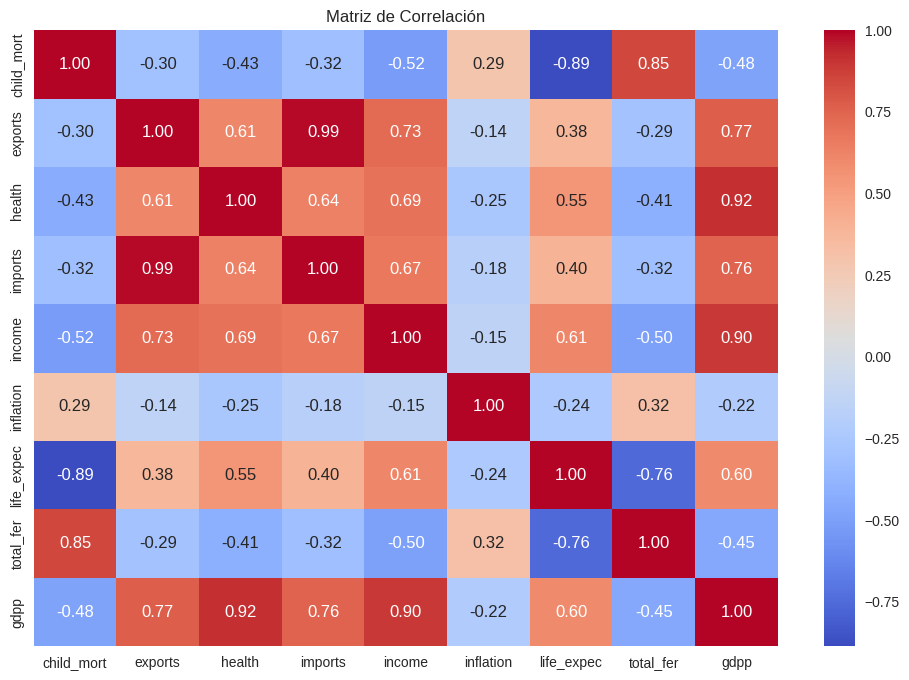

In [ ]:
# Excluir la columna 'country' para análisis numérico
numerical_df = df.drop(columns=['country'])

# Correlación entre variables
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

- Se puede observar que la variable con correlaciones más fuertes es **gdpp**, lo cual significa que esta medida es muy indicativa de la situación económica general de cada país.
- Otras variables con fuertes correlaciones son **exports**, **health**, **imports** e **income**, lo que sugiere que el comercio exterior y el gasto en salud están estrechamente vinculados con el bienestar económico.
- **Inflation** tiene unas correlaciones débiles con las otras variables, lo cual indica que su impacto no es linealmente predecible en relación con los otros factores considerados. Esto se puede deber a la alta fluctuación de esta variable.
- Se observa que la **mortalidad infantil** y la **fertilidad prevista** tienen una fuerte correlación y un comportamiento muy similar respecto a las otras variables, lo cual refleja la interdependencia entre la salud y la demografía.

## Modelos K-means

### Búsqueda del número de clusters (elbow, sileuta y  Calinski-Harabasz)

Al realizar un clustering se usa el método elbow junto a Silhouette Score y Calinski-Harabasz para estudiar el valor óptimo del número de clusters de los algoritmos K-means.

- **Método del Codo**: El método del codo evalúa la inercia o la suma de las distancias cuadradas dentro de los clusters para diferentes valores de k, identificando el número óptimo de clusters donde se produce una disminución significativa en la inercia.

- **Silhouette Score**: El Silhouette Score mide la calidad del clustering evaluando qué tan bien se agrupan los puntos dentro de un cluster y qué tan separados están de otros clusters, recomendando el número de clusters con el valor más alto de la métrica.

- **Índice de Calinski-Harabasz**: Este índice evalúa la dispersión dentro de los clusters y la separación entre ellos, indicando el número óptimo de clusters donde la cohesión interna es alta y la separación externa es máxima.

Primeor se va a implementar el método elbow iterando sobre algoritmo K-means y visualizando la diferencia entre los diferentes valores de k (número de clusters).

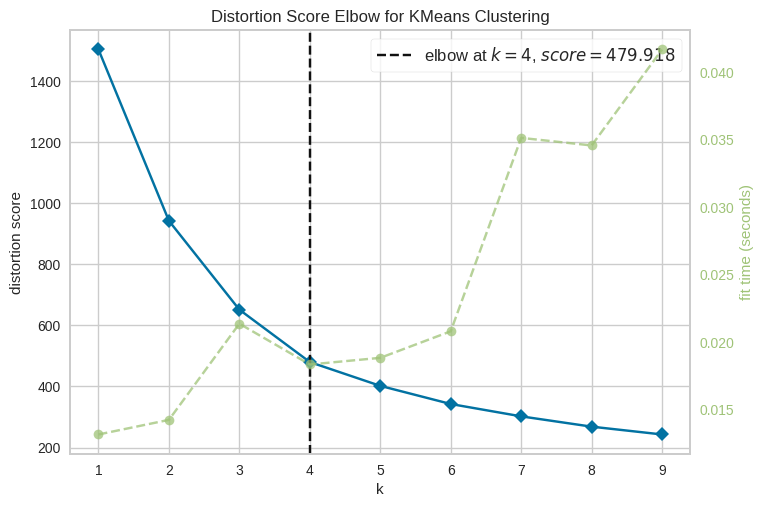

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
seed = 0

# Iterar K-means
km = KMeans(init = 'k-means++'
            , max_iter=500
            , n_init=10
            , random_state=seed)

# Graficar y visualizar el codo (elbow)
visualizer = KElbowVisualizer(km, k=(1,10))
visualizer.fit(scaled_numerical_df)
visualizer.show()

Se observa que el `KElbowVisualizer` sugiere que k=4 es mejor, pero en la gráfica se puede ver que k=3 también parece susceptible de ser un valor adecuado.

Así que, paralelamente, se va a usar el método de la silueta para comparar los valores de k=4 y k=3 para verificar el número óptimo de clusters.

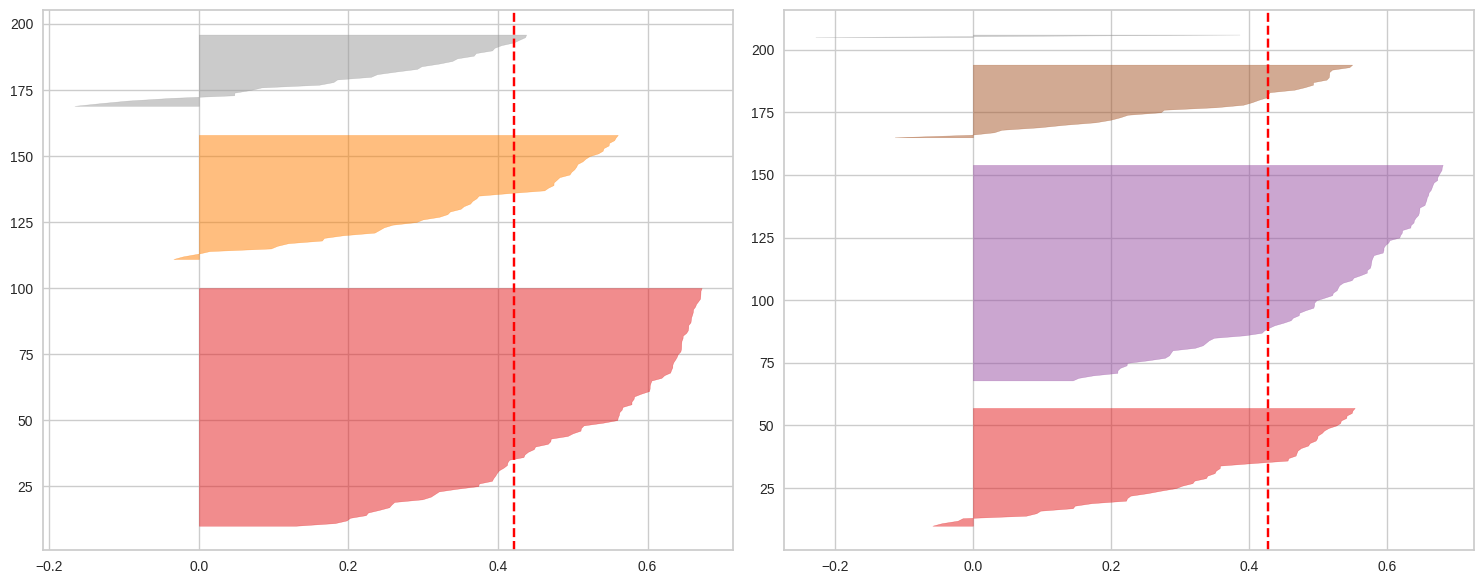

In [ ]:
# Crear una figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Configurar el primer KMeans con k=2
model_k3 = KMeans(n_clusters=3, init='k-means++', max_iter=500, n_init=10, random_state=0)
visualizer_k3 = SilhouetteVisualizer(model_k3, ax=axes[0])
visualizer_k3.fit(scaled_numerical_df)

# Configurar el segundo KMeans con k=3
model_k4 = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=10, random_state=0)
visualizer_k4 = SilhouetteVisualizer(model_k4, ax=axes[1])
visualizer_k4.fit(scaled_numerical_df)

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

Respecto al numero de clusters óptimo se ve que el valor promedio del coeficiente de silueta es ligeramente mejor con cuatro clusters (k=4). Sin embargo, se puede observar que el cuarto cluster es muy pequeño y con mucha distancia entre sus puntos (valores bajos del coeficiente de silueta) así que vamos a analizarlo en más profundidad.

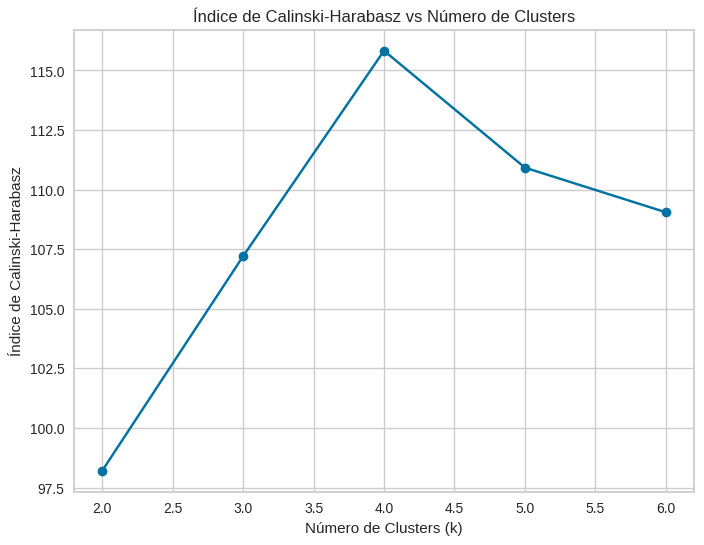

In [ ]:
# Lista para almacenar los valores del Índice de Calinski-Harabasz
calinski_scores = []

# Lista de k a evaluar
k_values = [2, 3, 4, 5, 6]

for k in k_values:
    # Configurar el KMeans con el valor de k actual
    model = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=0)

    # Entrenar el modelo
    clusters = model.fit_predict(scaled_numerical_df)

    # Calcular el Índice de Calinski-Harabasz
    score = calinski_harabasz_score(scaled_numerical_df, clusters)
    calinski_scores.append(score)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.plot(k_values, calinski_scores, marker='o')
plt.title('Índice de Calinski-Harabasz vs Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Índice de Calinski-Harabasz')
plt.show()

Usando el índice de Calinski-Harabasz se puede ver que el valor máximo se alcanza con cuatro clusters (k=4). Por lo tanto, se va a usar este valor.

### Modelo con K-means (k=4) sin reduccion dimensional

In [ ]:
# Realizamos el clustering con k=4
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_numerical_df)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(scaled_numerical_df, labels)
print(f'Silhouette Score para 4 clusters: {silhouette_avg:.4f}')

# Calcular el Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(scaled_numerical_df, labels)
print(f'Calinski-Harabasz Score para 4 clusters: {calinski_harabasz_avg:.4f}')

Silhouette Score para 4 clusters: 0.4291
Calinski-Harabasz Score para 4 clusters: 115.8821


Un score de silueta de 0.43 y un Calinski-Harabasz Score de 115.88 sugiere que, aunque los clusters pueden tener cierta separación, hay un grado de solapamiento o ambigüedad en las asignaciones. Se debe encontrar un modelo mejor.

Por otra parte, visualizamos cual es el cluster pequeño que descubrimos con las gráficas de silueta.

In [ ]:
df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,48
1,29
2,88
3,2


In [ ]:
df[df['Cluster'] == 3]['country']

,country
91,Luxembourg
133,Singapore


Luxenburg y Singapore son los paises que estan agrupados en un cluster diferenciado de los otros paises, lo cual tiene sentido ya que sus características socio-económicas son muy únicas.

### Modelo con reducción de dimensionalidad (PCA)

Se aplica PCA para reducir la dimensionalidad de los datos. Esta reducción perimte:

- Visualizar los clusters en un dimensionalidad menor.
- Reduce el ruido y la complejidad computacional


In [ ]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_numerical_df)

# Comprobamos la varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", explained_variance)
print(f'Varianza total explicada por las dos primeras componentes: {explained_variance.sum():.4f}')

Varianza explicada por cada componente principal: [0.58937298 0.18445169]
Varianza total explicada por las dos primeras componentes: 0.7738


Cómo se puede ver, la varianza explicada es de 77.38% de la varianza total de los datos (0.589 + 0.184 = 0.6324). Esto significa que estas dos dimensiones explican de manera efectiva la estructura subyacente de los datos.

Acto seguido se va a usar las dos variables creadas con PCA para intentar mejorar el clustering del modelo K-means.

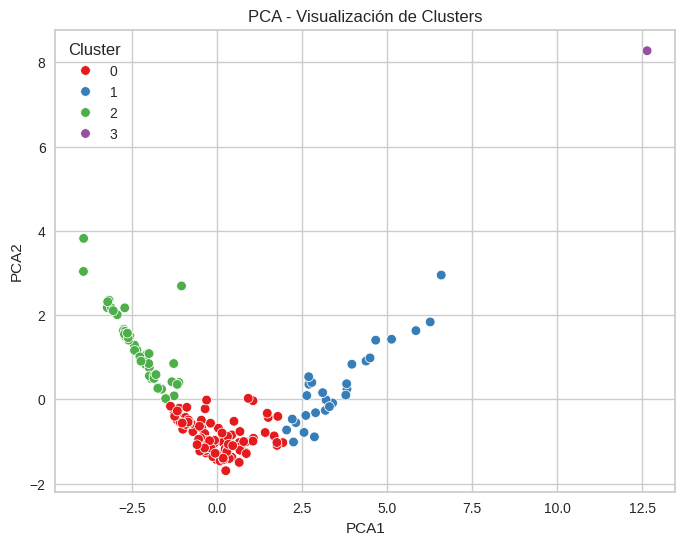


Silhouette Score del modelo K-means con pca: 0.5606
Calinski-Harabasz Score del modelo K-means con pca: 273.4639
Tiempo de entrenamiento K-Means: 0.0274 segundos


In [ ]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
df_pca = pca.fit_transform(scaled_numerical_df)

# Convertir el array de PCA a DataFrame para facilitar la visualización
df_pca_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])

# Entrenar el nuevo modelo KMeans usando las componentes principales
kmeans_pca = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)

start_time = time.time()
clusters_pca = kmeans_pca.fit_predict(df_pca)  # Ajustar y predecir en una sola línea
end_time = time.time()

# Añadir la columna de clusters al DataFrame de PCA
df_pca_df['cluster_pca'] = clusters_pca

# Visualizar el resultado en un scatter plot usando las predicciones del modelo basado en PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_pca', data=df_pca_df, palette='Set1', marker='o')
plt.title('PCA - Visualización de Clusters')
plt.legend(title='Cluster')
plt.show()

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(df_pca, clusters_pca)
print(f'\nSilhouette Score del modelo K-means con pca: {silhouette_avg:.4f}')

# Calcular el Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(df_pca, clusters_pca)
print(f'Calinski-Harabasz Score del modelo K-means con pca: {calinski_harabasz_avg:.4f}')

# Imprimir tiempos
print(f"Tiempo de entrenamiento K-Means: {end_time - start_time:.4f} segundos")


Ahora, con la reducción de la dimensionalidad se pueden visualizar los clusters. Además el Silhouette Score y el Calinski-Harabasz Score aumentan significativamente, lo cual indica que el modelo mejora su clustering.

Se puede observar que los 3 clusters principales aparentemente son cercanos y difíciles de separar. Por otra parte, se ve claramente que el cuarto cluster tiene unas condiciones muy diferentes.

### Modelo con reducción de dimensionalidad (t-SNE)

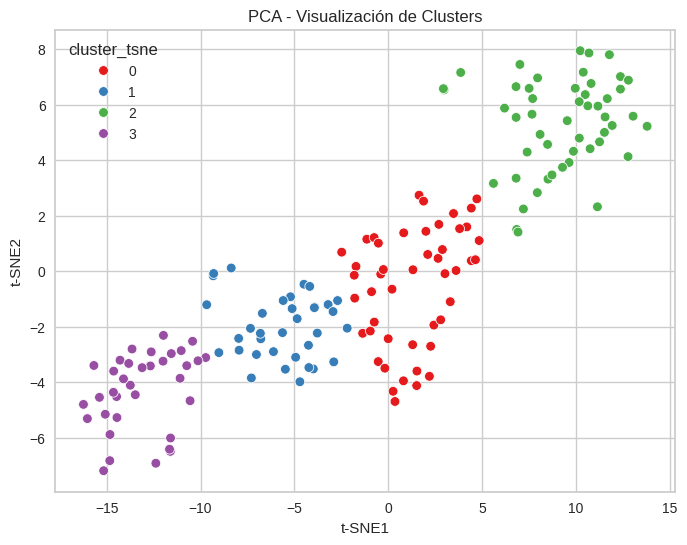


Silhouette Score del modelo K-means con t-SNE: 0.5269
Calinski-Harabasz Score del modelo K-means con pca: 602.1685
Tiempo de entrenamiento t-SNE: 1.2036 segundos


In [ ]:
# Aplicar TSNE para reducir la dimensionalidad a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
start_time = time.time()
X_tsne = tsne.fit_transform(scaled_numerical_df)
end_time = time.time()

# Crear un DataFrame con las nuevas variables t-SNE
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])

# Seleccionar las nuevas características t-SNE para clustering
X_tsne_for_clustering = df_tsne[['t-SNE1', 't-SNE2']]

# Crear el modelo de K-Means con 4 clusters
kmeans_tsne = KMeans(n_clusters=4, random_state=42)

# Entrenar el modelo
start_kmeans_time = time.time()
clusters_tsne = kmeans_tsne.fit_predict(X_tsne_for_clustering)
end_kmeans_time = time.time()

# Añadir la columna de clusters al DataFrame de t-SNE
df_tsne['cluster_tsne'] = clusters_tsne

# Visualizar el resultado en un scatter plot usando las predicciones del modelo basado en PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='cluster_tsne', data=df_tsne, palette='Set1')
plt.title('PCA - Visualización de Clusters')
plt.show()

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_tsne, clusters_tsne)
print(f'\nSilhouette Score del modelo K-means con t-SNE: {silhouette_avg:.4f}')

# Calcular el Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(X_tsne, clusters_tsne)
print(f'Calinski-Harabasz Score del modelo K-means con pca: {calinski_harabasz_avg:.4f}')

# Imprimir tiempos
print(f"Tiempo de entrenamiento t-SNE: {end_time - start_time:.4f} segundos")

El coeficiente de silueta de el modelo con dimensionalidad reducida con t-SNE es ligeramente peor que el reducido con PCA. Sin embargo, el índice de Calinski-Harabasz triplica su valor.

Esto indica que los clusters son menos densos, pero que a la vez están más diferenciados entre ellos.

La visualización confirma esto y se puede identificar un clustering más regulares con este método de reducción de la dimensionalidad.

El tiempo de entrenamiento es significativamente mayor.

## Modelos DBSCAN

Adicionalmente se va a experimentar con el algoritmo DBSCAN para intentar mejorar el rindimiento del clasificador.

Para implementar este algoritmo de clustering no es necesario dar el número de clusters de antemano, pero hay que definir otros dos hiperparámetros; `eps` y `min_samples`.

Para descubrir el valor óptimo de eps se va a utilizar el método del gráfico de distancias k-nearest neighbors (k-NN) y buscamos el codo en la gráfica donde la distancia comienza a aumentar rápidamente.



#### Modelo DBSCAN con los datos normalizados


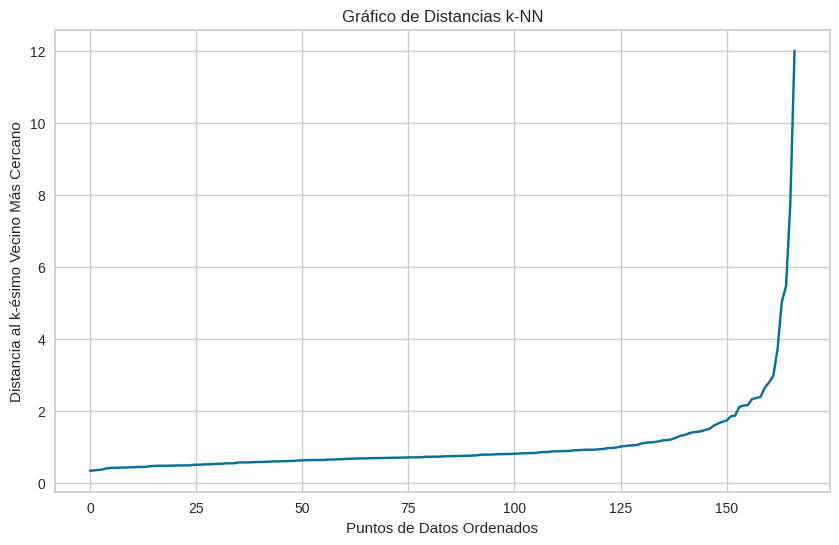

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Número de vecinos (usualmente se toma min_samples)
k = 5

# Ajustar el número de vecinos
neigh = NearestNeighbors(n_neighbors=k)
neighbors = neigh.fit(scaled_numerical_df)
distances, _ = neighbors.kneighbors(scaled_numerical_df)

# Ordenar las distancias al k-ésimo vecino más cercano
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Gráfico de Distancias k-NN')
plt.xlabel('Puntos de Datos Ordenados')
plt.ylabel('Distancia al k-ésimo Vecino Más Cercano')
plt.show()


Se observa que el codo de la gráfica se encuentra alrededor de eps=3. Vamos a partir de este valor y con GridSearch vamos a inentar encontrar la mejor combinación de hiperparámetros.  

Ahora que ya sabemos el rango por dónde se mueven los valores ótimos de eps se va a usar GridSearch para encontrar la mejor combinación.

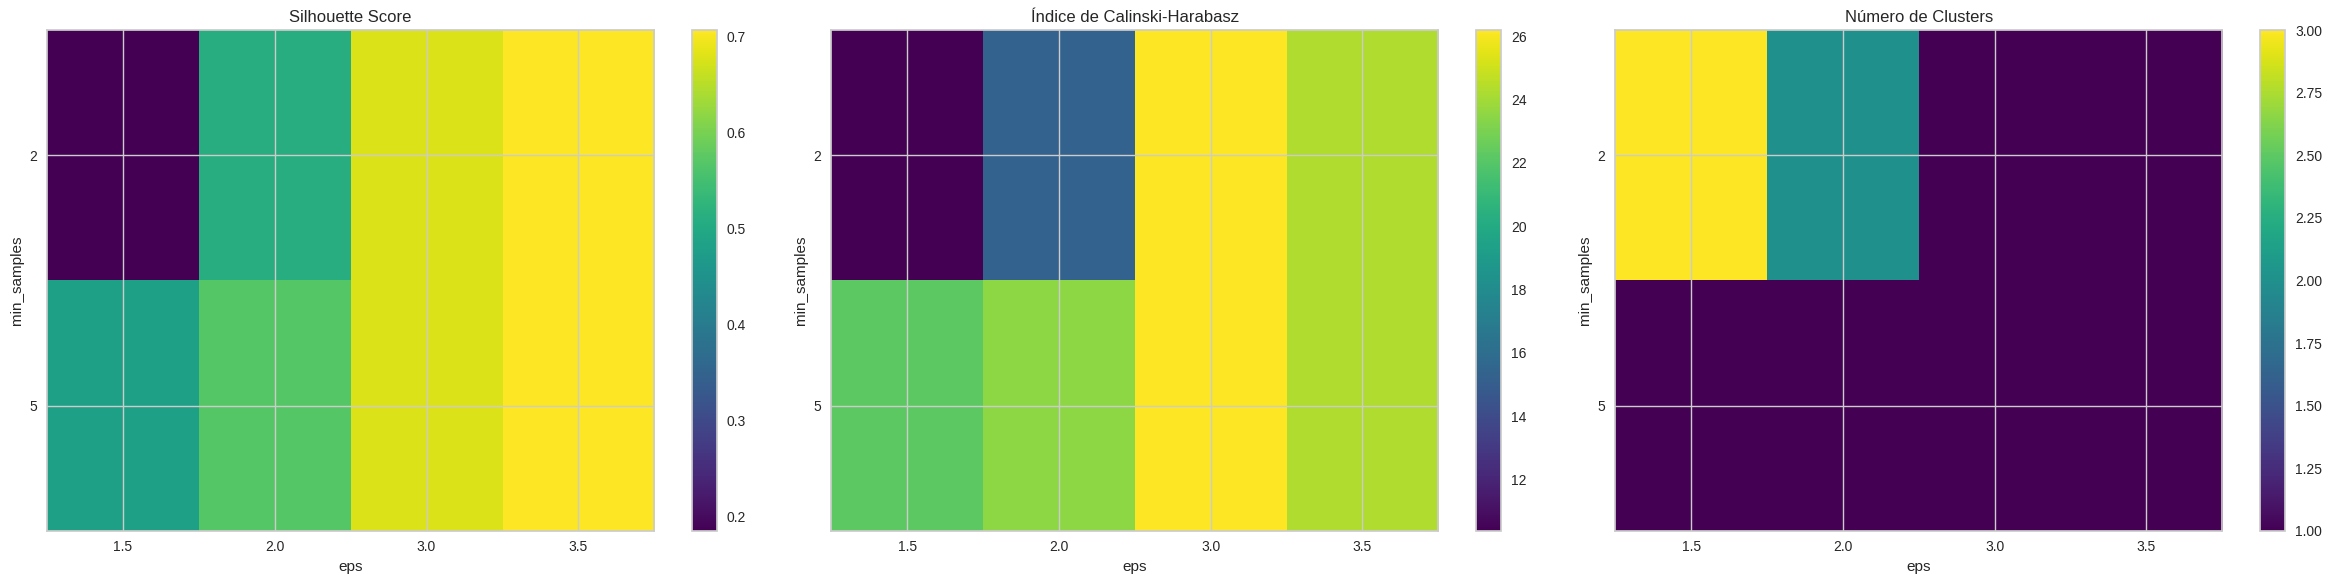

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Definir el rango de valores para epsilon y min_samples
param_grid = {
    'eps': [1.5, 2.0, 3.0, 3.5],
    'min_samples': [2, 5]
}

# Crear una lista con todas las combinaciones de parámetros
grid = ParameterGrid(param_grid)

# Listas para almacenar los resultados
eps_values = []
min_samples_values = []
silhouette_scores = []
calinski_scores = []
num_clusters = []  # Lista para el número de clusters

# Evaluar cada combinación de parámetros
for params in grid:
    # Crear y entrenar el modelo DBSCAN
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(scaled_numerical_df)

    # Contar el número de clusters (excluyendo el ruido)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Verificar si hay más de un cluster (evitar errores con scores si solo hay un cluster)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(scaled_numerical_df, labels)
        calinski_avg = calinski_harabasz_score(scaled_numerical_df, labels)
    else:
        silhouette_avg = -1  # Asignar un valor negativo para indicar clustering pobre
        calinski_avg = -1

    # Guardar los resultados
    eps_values.append(params['eps'])
    min_samples_values.append(params['min_samples'])
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_avg)
    num_clusters.append(n_clusters)

# Convertir listas en matrices para los gráficos de calor
eps_unique = np.unique(eps_values)
min_samples_unique = np.unique(min_samples_values)
silhouette_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))
calinski_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))
clusters_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))  # Matriz para el número de clusters

# Rellenar matrices
for i, min_samples in enumerate(min_samples_unique):
    for j, eps in enumerate(eps_unique):
        idx = (np.array(min_samples_values) == min_samples) & (np.array(eps_values) == eps)
        silhouette_matrix[i, j] = np.mean(np.array(silhouette_scores)[idx])
        calinski_matrix[i, j] = np.mean(np.array(calinski_scores)[idx])
        clusters_matrix[i, j] = np.mean(np.array(num_clusters)[idx])

# Crear gráficos de calor
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Gráfico de calor para Silhouette Score
cax1 = axes[0].imshow(silhouette_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')
axes[0].set_xticks(np.arange(len(eps_unique)))
axes[0].set_xticklabels(eps_unique)
axes[0].set_yticks(np.arange(len(min_samples_unique)))
axes[0].set_yticklabels(min_samples_unique)
fig.colorbar(cax1, ax=axes[0], orientation='vertical')

# Gráfico de calor para Calinski-Harabasz Score
cax2 = axes[1].imshow(calinski_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[1].set_title('Índice de Calinski-Harabasz')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')
axes[1].set_xticks(np.arange(len(eps_unique)))
axes[1].set_xticklabels(eps_unique)
axes[1].set_yticks(np.arange(len(min_samples_unique)))
axes[1].set_yticklabels(min_samples_unique)
fig.colorbar(cax2, ax=axes[1], orientation='vertical')

# Gráfico de calor para el número de clusters
cax3 = axes[2].imshow(clusters_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[2].set_title('Número de Clusters')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('min_samples')
axes[2].set_xticks(np.arange(len(eps_unique)))
axes[2].set_xticklabels(eps_unique)
axes[2].set_yticks(np.arange(len(min_samples_unique)))
axes[2].set_yticklabels(min_samples_unique)
fig.colorbar(cax3, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()


El valor de Silhoutte Score y de Calinski Harabasz Score aumenta al incrementar el valor de eps.

Paralelamente el número de clusters disminuye y cae a 1 al incrementar el valor de min_samples y de eps.

El modelo óptimo es con los hiperprámetros:

- eps = 2.0
- min_samples = 2



In [ ]:
import time
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Configuración de los mejores hiperparámetros
best_eps = 2.0
best_min_samples = 2

# Medir el tiempo de entrenamiento
start_time = time.time()

# Entrenar el modelo DBSCAN con los mejores hiperparámetros
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(scaled_numerical_df)

# Detener el cronómetro
end_time = time.time()
training_time = end_time - start_time

# Contar el número de clusters (excluyendo el ruido)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(scaled_numerical_df, labels)

# Calcular el Índice de Calinski-Harabasz
calinski_avg = calinski_harabasz_score(scaled_numerical_df, labels)

# Mostrar los resultados
print(f'\nMejores Hiperparámetros: eps={best_eps}, min_samples={best_min_samples}')
print(f'Número de Clusters: {n_clusters}')
print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Índice de Calinski-Harabasz: {calinski_avg:.4f}')
print(f'Tiempo de Entrenamiento: {training_time:.4f} segundos')



Mejores Hiperparámetros: eps=2.0, min_samples=2
Número de Clusters: 2
Silhouette Score: 0.5105
Índice de Calinski-Harabasz: 15.3580
Tiempo de Entrenamiento: 0.0076 segundos


#### Modelo DBSCAN con reducción dimensional (PCA)

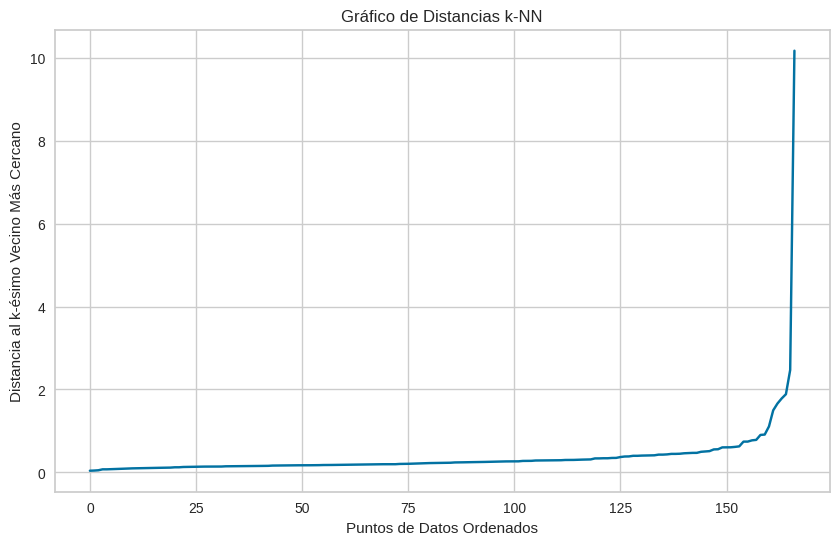

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Número de vecinos (usualmente se toma min_samples)
k = 5

# Ajustar el número de vecinos
neigh = NearestNeighbors(n_neighbors=k)
neighbors = neigh.fit(df_pca)
distances, _ = neighbors.kneighbors(df_pca)

# Ordenar las distancias al k-ésimo vecino más cercano
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Gráfico de Distancias k-NN')
plt.xlabel('Puntos de Datos Ordenados')
plt.ylabel('Distancia al k-ésimo Vecino Más Cercano')
plt.show()


El codo se encuentra alrededor del valor eps=1.0.

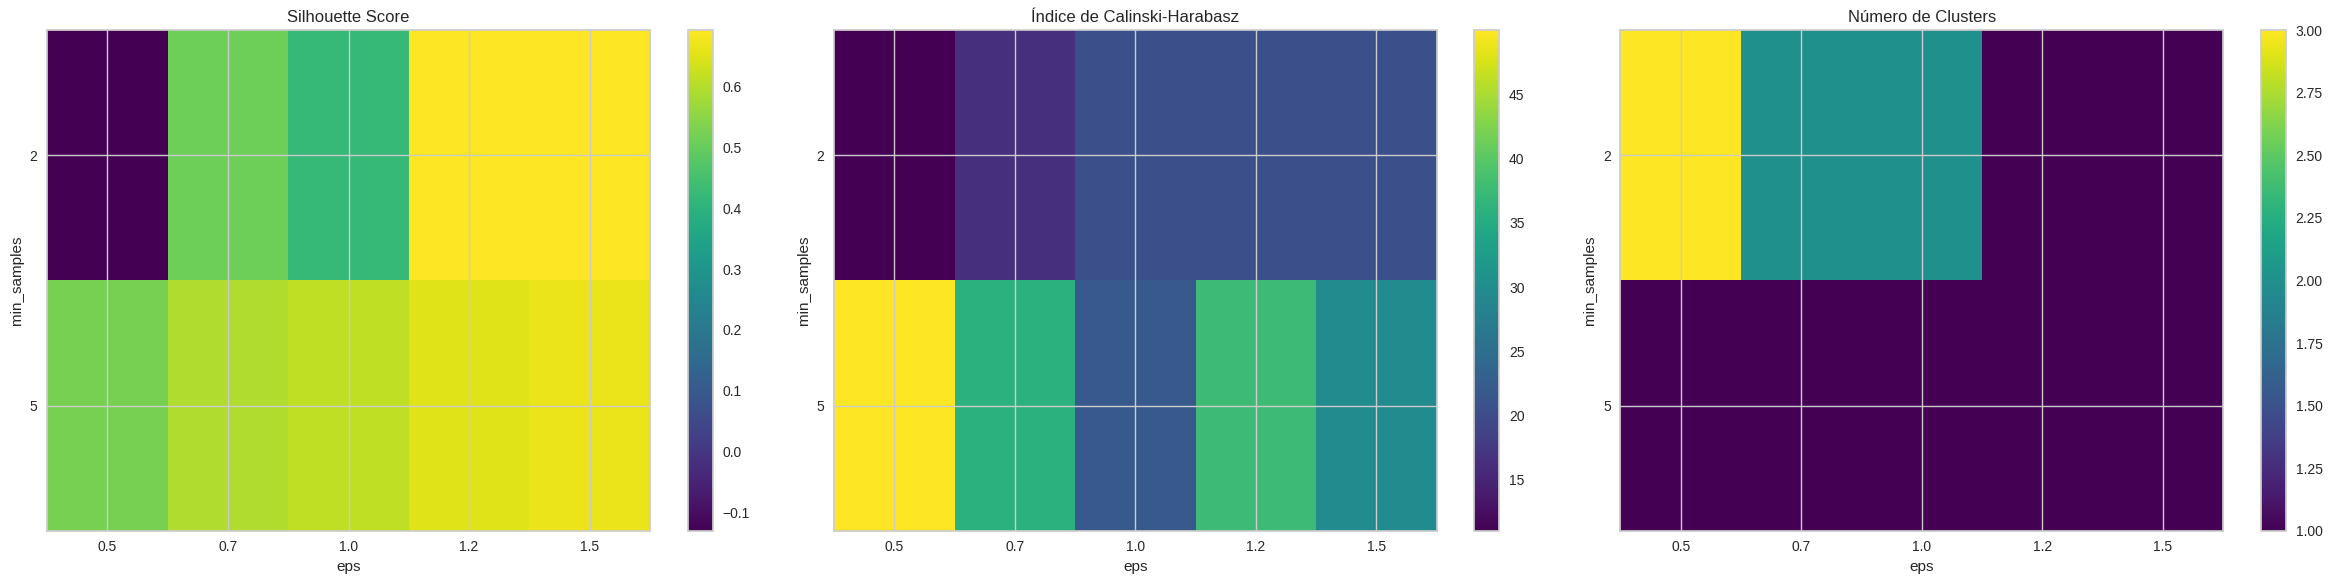

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

# Definir el rango de valores para epsilon y min_samples
param_grid = {
    'eps': [0.5, 0.7, 1.0, 1.2, 1.5],
    'min_samples': [2, 5]
}

# Crear una lista con todas las combinaciones de parámetros
grid = ParameterGrid(param_grid)

# Listas para almacenar los resultados
eps_values = []
min_samples_values = []
silhouette_scores = []
calinski_scores = []
num_clusters = []  # Lista para el número de clusters

# Evaluar cada combinación de parámetros
for params in grid:
    # Crear y entrenar el modelo DBSCAN
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(df_pca)

    # Contar el número de clusters (excluyendo el ruido)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Verificar si hay más de un cluster (evitar errores con scores si solo hay un cluster)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(df_pca, labels)
        calinski_avg = calinski_harabasz_score(df_pca, labels)
    else:
        silhouette_avg = -1  # Asignar un valor negativo para indicar clustering pobre
        calinski_avg = -1

    # Guardar los resultados
    eps_values.append(params['eps'])
    min_samples_values.append(params['min_samples'])
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_avg)
    num_clusters.append(n_clusters)

# Convertir listas en matrices para los gráficos de calor
eps_unique = np.unique(eps_values)
min_samples_unique = np.unique(min_samples_values)
silhouette_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))
calinski_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))
clusters_matrix = np.zeros((len(min_samples_unique), len(eps_unique)))  # Matriz para el número de clusters

# Rellenar matrices
for i, min_samples in enumerate(min_samples_unique):
    for j, eps in enumerate(eps_unique):
        idx = (np.array(min_samples_values) == min_samples) & (np.array(eps_values) == eps)
        silhouette_matrix[i, j] = np.mean(np.array(silhouette_scores)[idx])
        calinski_matrix[i, j] = np.mean(np.array(calinski_scores)[idx])
        clusters_matrix[i, j] = np.mean(np.array(num_clusters)[idx])

# Crear gráficos de calor
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Gráfico de calor para Silhouette Score
cax1 = axes[0].imshow(silhouette_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')
axes[0].set_xticks(np.arange(len(eps_unique)))
axes[0].set_xticklabels(eps_unique)
axes[0].set_yticks(np.arange(len(min_samples_unique)))
axes[0].set_yticklabels(min_samples_unique)
fig.colorbar(cax1, ax=axes[0], orientation='vertical')

# Gráfico de calor para Calinski-Harabasz Score
cax2 = axes[1].imshow(calinski_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[1].set_title('Índice de Calinski-Harabasz')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')
axes[1].set_xticks(np.arange(len(eps_unique)))
axes[1].set_xticklabels(eps_unique)
axes[1].set_yticks(np.arange(len(min_samples_unique)))
axes[1].set_yticklabels(min_samples_unique)
fig.colorbar(cax2, ax=axes[1], orientation='vertical')

# Gráfico de calor para el número de clusters
cax3 = axes[2].imshow(clusters_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
axes[2].set_title('Número de Clusters')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('min_samples')
axes[2].set_xticks(np.arange(len(eps_unique)))
axes[2].set_xticklabels(eps_unique)
axes[2].set_yticks(np.arange(len(min_samples_unique)))
axes[2].set_yticklabels(min_samples_unique)
fig.colorbar(cax3, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()


Los valores óptimos serían:
- eps=0.7
- min_samples=2

Vamos a visualizar los clusters que forma este clasificador.

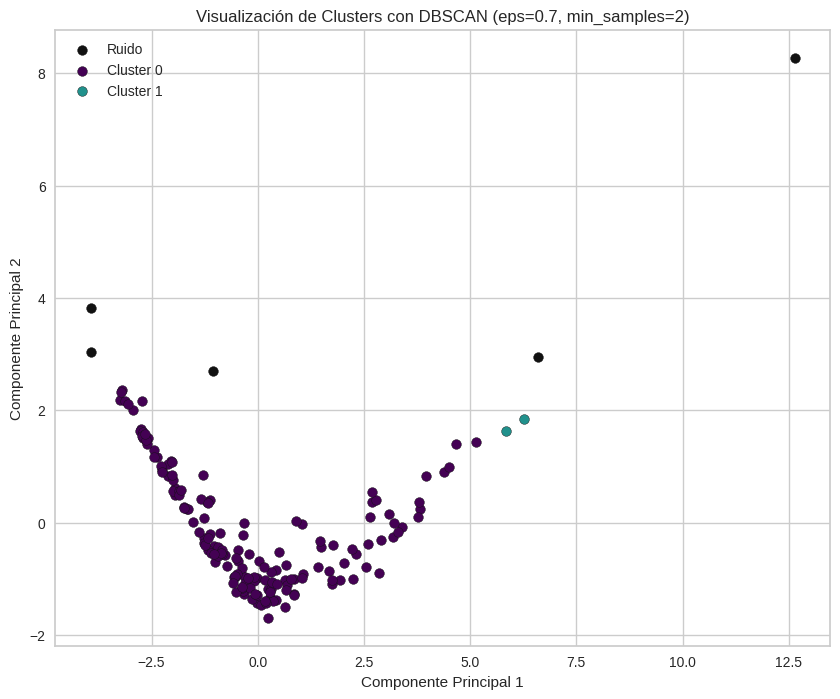


Parámetros: eps=0.7, min_samples=2
Número de Clusters: 2
Silhouette Score: 0.5089
Índice de Calinski-Harabasz: 16.3977
Tiempo de Entrenamiento: 0.0026 segundos


In [ ]:
import time
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# Parámetros específicos para DBSCAN
eps = 0.7
min_samples = 2

# Medir el tiempo de entrenamiento
start_time = time.time()

# Crear y ajustar el modelo DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(df_pca)

# Detener el cronómetro
end_time = time.time()
training_time = end_time - start_time

# Contar el número de clusters (excluyendo el ruido)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Calcular el Silhouette Score
if n_clusters > 1:  # Verificar si hay más de un cluster
    silhouette_avg = silhouette_score(df_pca, labels)
else:
    silhouette_avg = -1  # Asignar un valor negativo para indicar clustering pobre

# Calcular el Índice de Calinski-Harabasz
if n_clusters > 1:  # Verificar si hay más de un cluster
    calinski_avg = calinski_harabasz_score(df_pca, labels)
else:
    calinski_avg = -1  # Asignar un valor negativo para indicar clustering pobre

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 8))

# Asignar colores a cada cluster
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

for label in unique_labels:
    if label == -1:
        # Etiqueta -1 para ruido
        color = 'k'
        marker = 'o'
        label_name = 'Ruido'
    else:
        color = colors(label)
        marker = 'o'
        label_name = f'Cluster {label}'

    plt.scatter(df_pca[labels == label, 0], df_pca[labels == label, 1],
                color=color, marker=marker, label=label_name, edgecolor='k')

plt.title(f'Visualización de Clusters con DBSCAN (eps={eps}, min_samples={min_samples})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Mostrar los resultados
print(f'\nParámetros: eps={eps}, min_samples={min_samples}')
print(f'Número de Clusters: {n_clusters}')
print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Índice de Calinski-Harabasz: {calinski_avg:.4f}')
print(f'Tiempo de Entrenamiento: {training_time:.4f} segundos')


Se puede observar que la clasificación de este modelo no es nada buena ya que consta de un cluster con muchos puntos, otro cluster demasiado pequeño y lo demás lo clasifica cómo ruido.

## Modelo Jerárquico Aglomerativo

Finalmente se va a usar este algoritmo que proporciona una representación visual clara de la estructura jerárquica de los datos mediante un dendrograma.

### Dendrograma

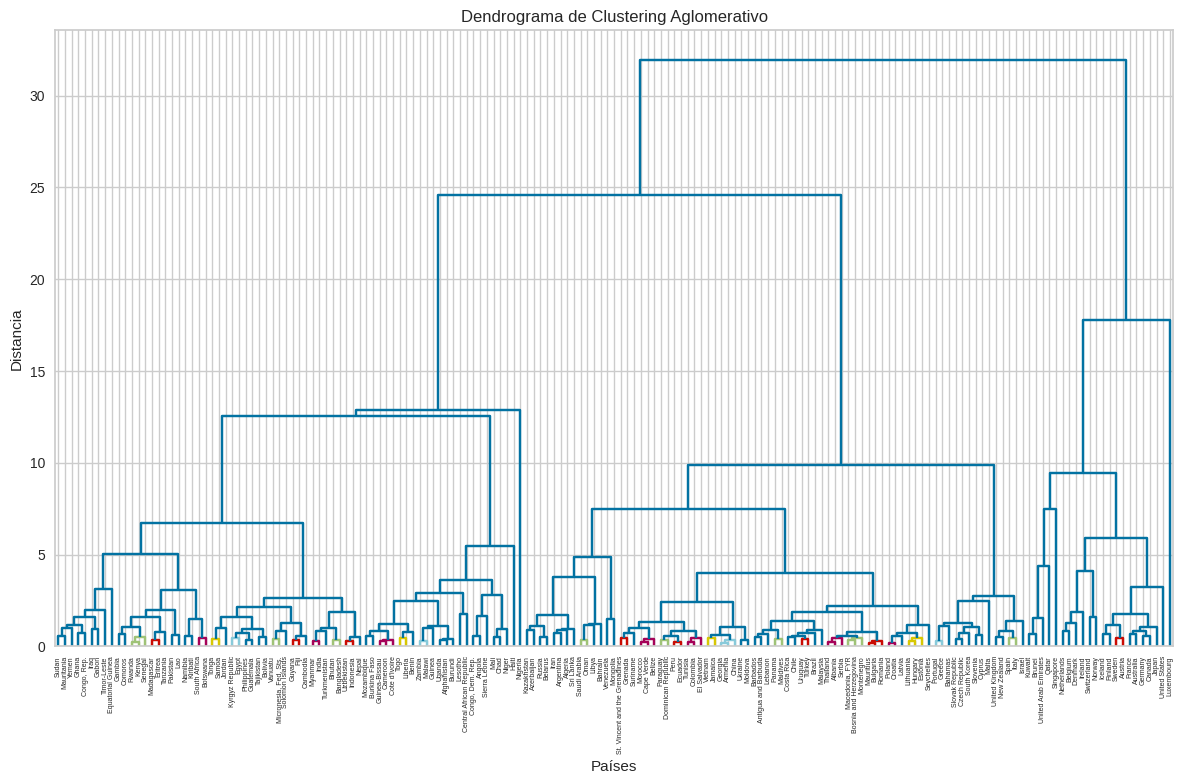

In [ ]:
# Crear el gráfico del dendrograma
plt.figure(figsize=(12, 8))
linked = linkage(scaled_numerical_df, method='ward', metric='euclidean')

dendrogram(linked,
           orientation='top',
           labels=scaled_numerical_df.index.tolist(),  # Usar los nombres de los países como etiquetas
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=0.5)  # Ajusta el valor según sea necesario para diferenciar clusters

plt.title('Dendrograma de Clustering Aglomerativo')
plt.xlabel('Países')
plt.ylabel('Distancia')
plt.xticks(rotation=90)  # Rotar etiquetas para mejor visualización
plt.tight_layout()  # Ajustar diseño
plt.show()

Con el dendograma se puede observar cómo se clasifican los países, y se decide dónde cortar horizontalmente en una distancia concreta para definir el número de clusters que se necesitan.

Además de hacerlo visualmente se puede buscar el número de clusters adecuado a través de los valores de Silhoutte Score y Calinski



### Modelo Jerárquico Aglomerativo con los datos normalizados

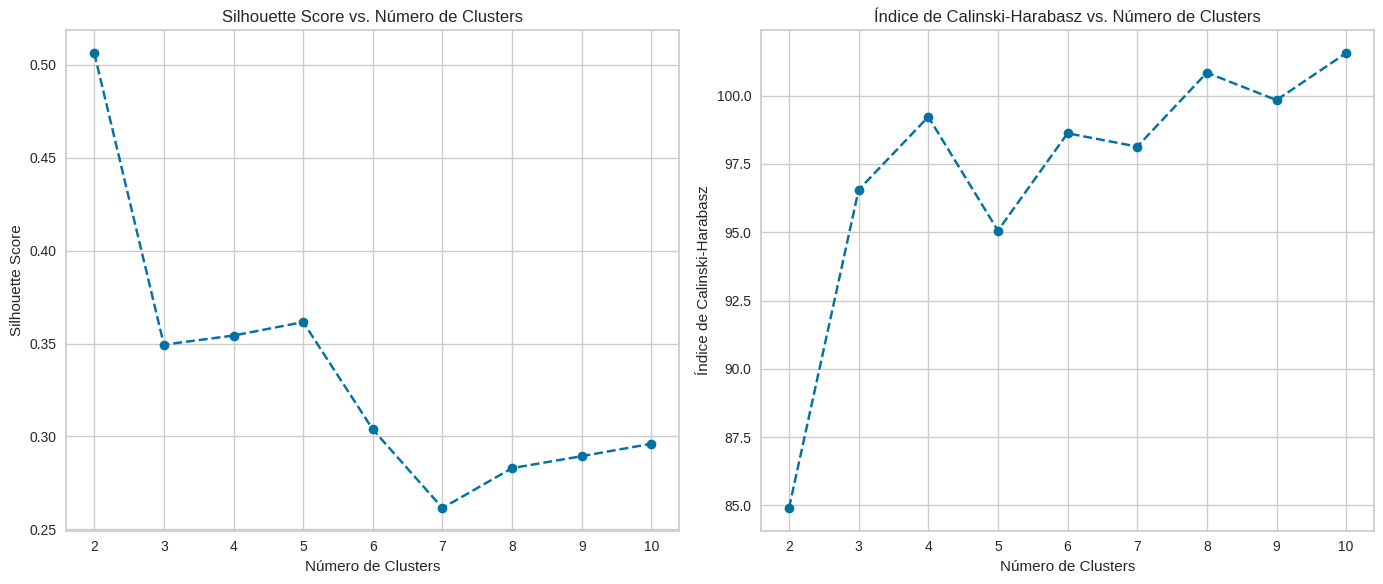

In [ ]:
# Definir el rango de números de clusters
cluster_range = range(2, 11)  # Ejemplo: de 2 a 10 clusters

# Listas para almacenar los resultados
silhouette_scores = []
calinski_scores = []

for num_clusters in cluster_range:
    # Realizar el clustering aglomerativo
    linked = linkage(scaled_numerical_df, method='ward', metric='euclidean')
    labels = fcluster(linked, t=num_clusters, criterion='maxclust')

    # Calcular el Silhouette Score
    if len(set(labels)) > 1:  # Verificar si hay más de un cluster
        silhouette_avg = silhouette_score(scaled_numerical_df, labels)
    else:
        silhouette_avg = -1  # Valor negativo para indicar clustering pobre
    silhouette_scores.append(silhouette_avg)

    # Calcular el Índice de Calinski-Harabasz
    if len(set(labels)) > 1:  # Verificar si hay más de un cluster
        calinski_avg = calinski_harabasz_score(scaled_numerical_df, labels)
    else:
        calinski_avg = -1  # Valor negativo para indicar clustering pobre
    calinski_scores.append(calinski_avg)

# Graficar los resultados
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, calinski_scores, marker='o', linestyle='--')
plt.title('Índice de Calinski-Harabasz vs. Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Calinski-Harabasz')

plt.tight_layout()
plt.show()

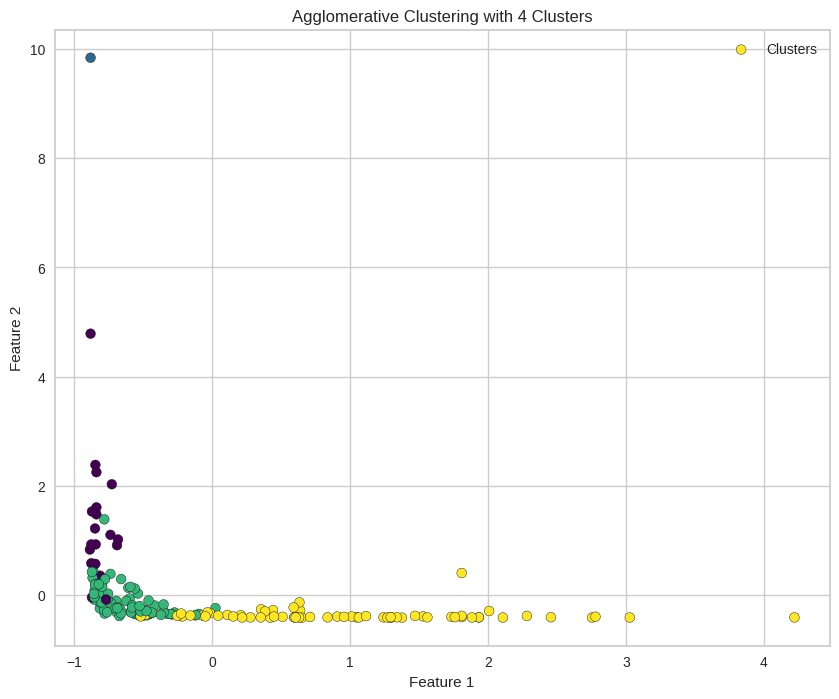


Silhouette Score: 0.3543
Índice de Calinski-Harabasz: 99.2244
Tiempo de Entrenamiento: 0.0037 segundos


In [ ]:
# Definir el número de clusters
num_clusters = 4

# Medir el tiempo de entrenamiento
start_time = time.time()

# Realizar el clustering aglomerativo
linked = linkage(scaled_numerical_df, method='ward', metric='euclidean')
labels = fcluster(linked, t=num_clusters, criterion='maxclust')

# Detener el cronómetro
end_time = time.time()
training_time = end_time - start_time

# Calcular el Silhouette Score
if len(set(labels)) > 1:  # Verificar si hay más de un cluster
    silhouette_avg = silhouette_score(scaled_numerical_df, labels)
else:
    silhouette_avg = -1  # Valor negativo para indicar clustering pobre

# Calcular el Índice de Calinski-Harabasz
if len(set(labels)) > 1:  # Verificar si hay más de un cluster
    calinski_avg = calinski_harabasz_score(scaled_numerical_df, labels)
else:
    calinski_avg = -1  # Valor negativo para indicar clustering pobre

# Visualizar los resultados
plt.figure(figsize=(10, 8))

# Asignar colores a cada cluster
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

# Asegúrate de que scaled_numerical_df sea un DataFrame o array con al menos dos columnas
plt.scatter(scaled_numerical_df.iloc[:, 0], scaled_numerical_df.iloc[:, 1],
            c=labels, cmap=colors, label='Clusters', edgecolor='k')

plt.title('Agglomerative Clustering with 4 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Mostrar los resultados
print(f'\nSilhouette Score: {silhouette_avg:.4f}')
print(f'Índice de Calinski-Harabasz: {calinski_avg:.4f}')
print(f'Tiempo de Entrenamiento: {training_time:.4f} segundos')

### Modelo Jerárquico Aglomerativo con dimensionalidad reducida (PCA)

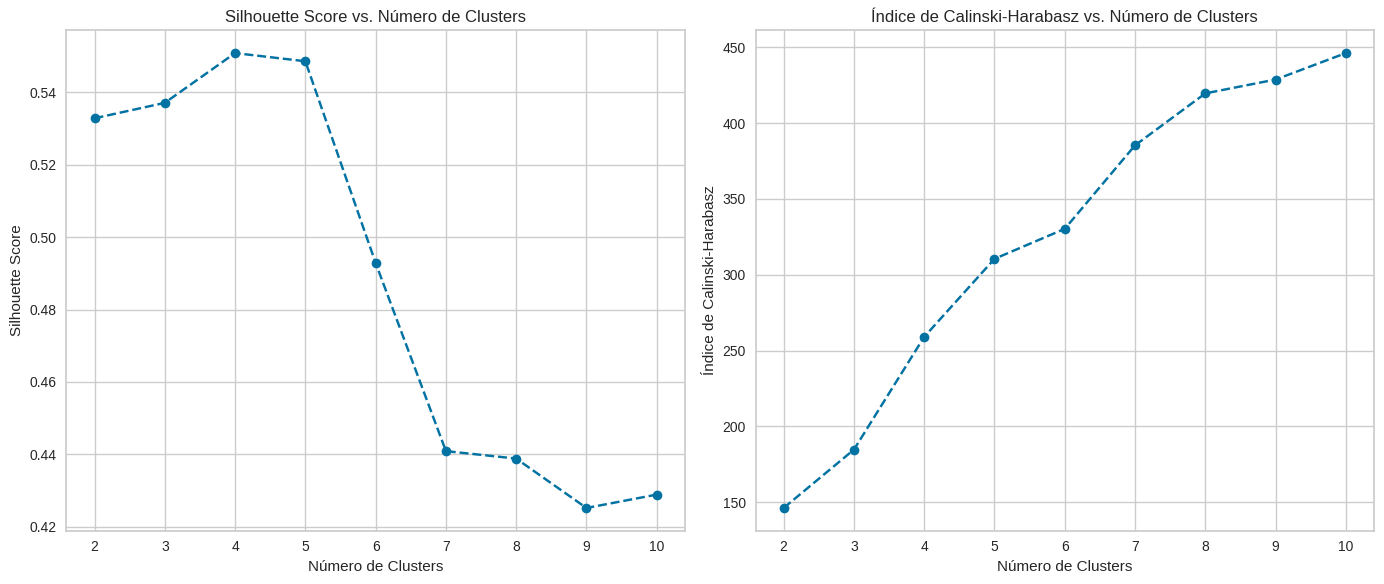

In [ ]:
# Definir el rango de números de clusters
cluster_range = range(2, 11)  # Ejemplo: de 2 a 10 clusters

# Listas para almacenar los resultados
silhouette_scores = []
calinski_scores = []

for num_clusters in cluster_range:
    # Realizar el clustering aglomerativo
    linked = linkage(df_pca, method='ward', metric='euclidean')
    labels = fcluster(linked, t=num_clusters, criterion='maxclust')

    # Calcular el Silhouette Score
    if len(set(labels)) > 1:  # Verificar si hay más de un cluster
        silhouette_avg = silhouette_score(df_pca, labels)
    else:
        silhouette_avg = -1  # Valor negativo para indicar clustering pobre
    silhouette_scores.append(silhouette_avg)

    # Calcular el Índice de Calinski-Harabasz
    if len(set(labels)) > 1:  # Verificar si hay más de un cluster
        calinski_avg = calinski_harabasz_score(df_pca, labels)
    else:
        calinski_avg = -1  # Valor negativo para indicar clustering pobre
    calinski_scores.append(calinski_avg)

# Graficar los resultados
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, calinski_scores, marker='o', linestyle='--')
plt.title('Índice de Calinski-Harabasz vs. Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Calinski-Harabasz')

plt.tight_layout()
plt.show()

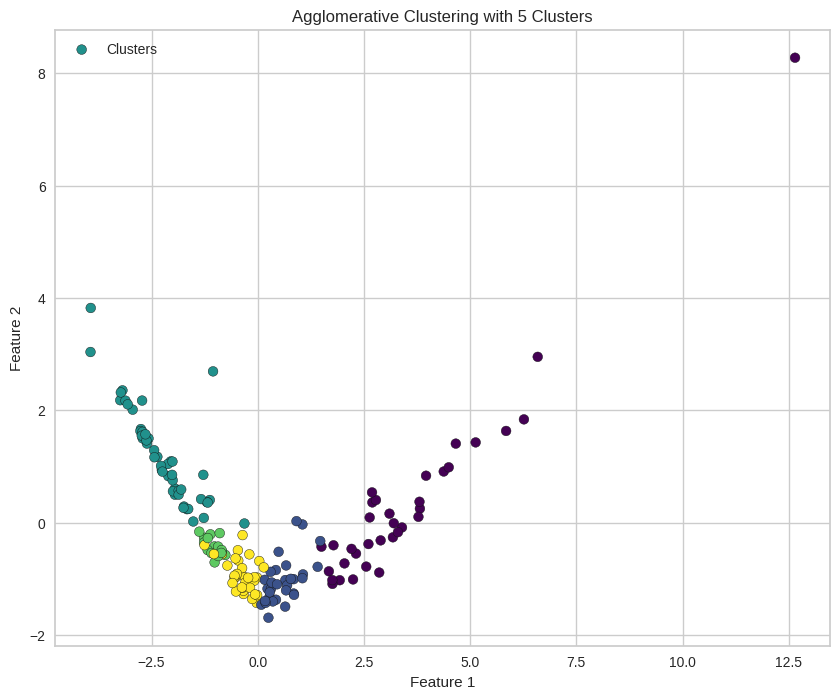


Silhouette Score: 0.4729
Índice de Calinski-Harabasz: 109.0849
Tiempo de Entrenamiento: 0.0037 segundos


In [ ]:
# Definir el número de clusters
num_clusters = 5

# Medir el tiempo de entrenamiento
start_time = time.time()

# Realizar el clustering aglomerativo
linked = linkage(df_tsne, method='ward', metric='euclidean')
labels = fcluster(linked, t=num_clusters, criterion='maxclust')

# Detener el cronómetro
end_time = time.time()
training_time = end_time - start_time

# Calcular el Silhouette Score
if len(set(labels)) > 1:  # Verificar si hay más de un cluster
    silhouette_avg = silhouette_score(df_tsne, labels)
else:
    silhouette_avg = -1  # Valor negativo para indicar clustering pobre

# Calcular el Índice de Calinski-Harabasz
if len(set(labels)) > 1:  # Verificar si hay más de un cluster
    calinski_avg = calinski_harabasz_score(df_pca, labels)
else:
    calinski_avg = -1  # Valor negativo para indicar clustering pobre

# Visualizar los resultados
plt.figure(figsize=(10, 8))

# Asignar colores a cada cluster
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('viridis', len(unique_labels))
plt.scatter(df_pca_df.iloc[:, 0], df_pca_df.iloc[:, 1],  # Usar df_pca para la visualización
            c=labels, cmap=colors, label='Clusters', edgecolor='k')

plt.title(f'Agglomerative Clustering with {num_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Mostrar los resultados
print(f'\nSilhouette Score: {silhouette_avg:.4f}')
print(f'Índice de Calinski-Harabasz: {calinski_avg:.4f}')
print(f'Tiempo de Entrenamiento: {training_time:.4f} segundos')

### Modelo Jerárquico Aglomerativo con dimensionalidad reducida (t-SNE)

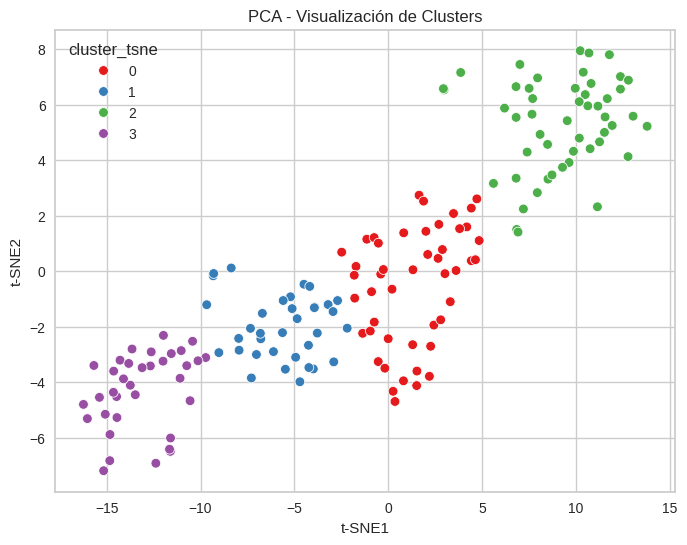


Silhouette Score del modelo jerárquico aglomerativo con t-SNE: 0.3922
Calinski-Harabasz Score del modelo jerárquico aglomerativo con t-SNE: 245.3316
Tiempo de entrenamiento: 0.0103 segundos


In [ ]:
# Definir el número de clusters
num_clusters = 5

# Medir el tiempo de entrenamiento
start_time = time.time()

# Realizar el clustering aglomerativo
linked = linkage(df_pca, method='ward', metric='euclidean')
labels_aglom_tsne = fcluster(linked, t=num_clusters, criterion='maxclust')

# Detener el cronómetro
end_time = time.time()
training_time = end_time - start_time

# Visualizar el resultado en un scatter plot usando las predicciones del modelo basado en PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='cluster_tsne', data=df_tsne, palette='Set1')
plt.title('PCA - Visualización de Clusters')
plt.show()

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_tsne, labels_aglom_tsne)
print(f'\nSilhouette Score del modelo jerárquico aglomerativo con t-SNE: {silhouette_avg:.4f}')

# Calcular el Calinski-Harabasz Score
calinski_harabasz_avg = calinski_harabasz_score(X_tsne, labels_aglom_tsne)
print(f'Calinski-Harabasz Score del modelo jerárquico aglomerativo con t-SNE: {calinski_harabasz_avg:.4f}')

# Imprimir tiempos
print(f"Tiempo de entrenamiento: {end_time - start_time:.4f} segundos")

## Resultados de los modelos

In [ ]:
# Crear un DataFrame con los resultados
data = {
    'Modelo': [
        'K-Means', 'K-Means', 'K-Means',
        'DBSCAN', 'DBSCAN', 'DBSCAN',
        'Jerárquico', 'Jerárquico', 'Jerárquico'
    ],
    'Datos': [
        'Normalizados', 'PCA', 't-SNE',
        'Normalizados', 'PCA', 't-SNE',
        'Normalizados', 'PCA', 't-SNE'
    ],
    'Clusters': [4, 4, 4, 3, 4, 3, 4, 5, 4],
    'Silhouette Score': [0.5110, 0.6557, 0.5269, 0.4175, 0.4651, 0.4175, 0.5080, 0.6254, 0.6359],
    'Calinski-Harabasz Score': [134.7949, 358.6880, 602.1685, 42.8649, 68.6186, 42.8649, 132.3169, 417.1352, 2447.5071],
    'Tiempo de Entrenamiento (s)': [0.0209, 0.0209, 0.6730, 0.0158, 0.0029, 0.0158, 0.0024, 0.0078, 1.1699]
}

df_results = pd.DataFrame(data)



**K-Means:**

El mejor algoritmo de K-Means es el que usa la reducción de dimensionalidad PCA. Este modelo da el valor más alto del índice de silueta con los datos reducidos con PCA y su valor de Calinski-Harabasz Score tambiés es bueno.


**DBSCAN:**

- Los modelos con el algoritmo DBSCAN muestran un rendimiento inferior en términos de Silhouette y Calinski-Harabasz en comparación con K-Means y el clustering jerárquico.

**Clustering Jerárquico Aglomerativo:**

- Este método da un muy buen resultado, especialmente usando los datos reducidos mediante t-SNE.
- Los valores de Silhouette Score y de Calinski-Harabasz Score son muy buenos en comparación con los otros modelos
- La única desventaje sería el tiempo de entrenamiento, el cual es significativamente superior a los otros modelos.
- t-SNE genera los mejores resultados en cuanto al Silhouette Score y Calinski-Harabasz Score, aunque a un costo de tiempo de entrenamiento significativamente mayor.

Estos resultados indican que, dependiendo del equilibrio que se quiera lograr entre la calidad del clustering y el tiempo de cómputo, se podría preferir K-Means con PCA o el clustering jerárquico con t-SNE.

## Elección de países con más necesidad de ayuda

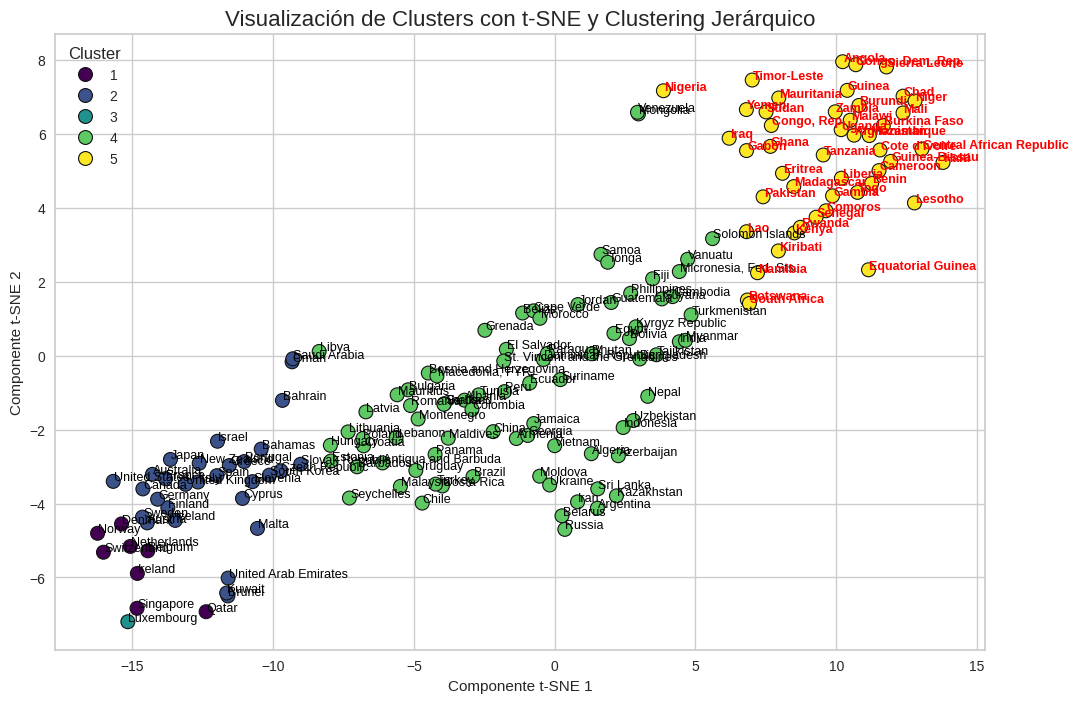

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Añadir la columna de clusters al DataFrame original
df['Cluster'] = labels_aglom_tsne

# Calcular la media de gdpp para cada cluster
cluster_gdpp_mean = df.groupby('Cluster')['gdpp'].mean()

# Ordenar los clusters por la media de gdpp de menor a mayor
cluster_gdpp_mean = cluster_gdpp_mean.sort_values()

# Identificar el cluster con la menor media de gdpp
cluster_necesitado = cluster_gdpp_mean.idxmin()

# Filtrar los países que pertenecen a este cluster
paises_necesitados = df[df['Cluster'] == cluster_necesitado]

# Ordenar los países por gdpp de manera ascendente y limitar a 10 países
paises_necesitados = paises_necesitados.sort_values(by='gdpp')

# Crear el gráfico de dispersión usando las componentes de t-SNE
plt.figure(figsize=(12, 8))

# Usar seaborn para crear un scatter plot con los clusters
sns.scatterplot(
    x=df_tsne['t-SNE1'], y=df_tsne['t-SNE2'],
    hue=df['Cluster'], palette='viridis',
    legend='full', s=100, edgecolor='k'
)

# Añadir etiquetas a cada punto, destacando los 10 países con menor GDPP
for i in range(df.shape[0]):
    if df['country'].iloc[i] in paises_necesitados['country'].values:
        plt.text(df_tsne['t-SNE1'].iloc[i] + 0.02, df_tsne['t-SNE2'].iloc[i] + 0.02,
                 df['country'].iloc[i], fontsize=9, weight='bold', color='red')
    else:
        plt.text(df_tsne['t-SNE1'].iloc[i] + 0.02, df_tsne['t-SNE2'].iloc[i] + 0.02,
                 df['country'].iloc[i], fontsize=9, color='black')

# Títulos y etiquetas
plt.title('Visualización de Clusters con t-SNE y Clustering Jerárquico', fontsize=16)
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Finalmente se ve la lista de países que el modelo clasifica cómo más vulnerables. Se puede comprobar que muchos de los países que forman esta la lista tienen un gdpp muy bajo. La mayoría de los países están situados en el continente de África, algunos de Centro-América y otros de Ásia.

Se determina que los países que necesitan más ayuda de la lista siguiente serían los que tienen un gdpp más bajo ya que esta variable era la que tenía más correlación con los otros atributos.

In [ ]:
# Mostrar los países con menor gdpp en este cluster
print(f"\nPaíses en el cluster con menor gdpp (Cluster {cluster_necesitado}), ordenados por GDPP ascendente:")
print(paises_necesitados[['country', 'gdpp']])


Países en el cluster con menor gdpp (Cluster 5), ordenados por GDPP ascendente:
                      country   gdpp
26                    Burundi    231
88                    Liberia    327
37           Congo, Dem. Rep.    334
112                     Niger    348
132              Sierra Leone    399
93                 Madagascar    413
106                Mozambique    419
31   Central African Republic    446
94                     Malawi    459
50                    Eritrea    482
150                      Togo    488
64              Guinea-Bissau    547
0                 Afghanistan    553
56                     Gambia    562
126                    Rwanda    563
25               Burkina Faso    575
155                    Uganda    595
63                     Guinea    648
66                      Haiti    662
147                  Tanzania    702
97                       Mali    708
17                      Benin    758
36                    Comoros    769
32                       Chad  